# Exploratory Data Analysis: Defensemen Position

Recall that our **y**-values are the proportion of the salary cap that a general manager is willing to spend on a player in a given year. To estimate how much this value is, given a players performance metrics, we need to dive into the data and figure out what metrics have a strong relationship with our **y**'s.

Based on my knowledge of hockey, I suspect that the features will differ for the different positions that exist in hockey: Center, Forward, Defence, and Goalie. Here I will explore the data with respect to the defensemen position.

In [2]:
import pandas as pd
import dataprep as dp
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import plot

In [3]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv'
data = pd.read_csv(filepath)

data.shape

(12149, 124)

Now we need to select only those players that play Defense.

In [4]:
# Get all the unique values in the 'Position' col
data['POSITION'].unique()

array(['r', 'd', 'l', 'c, l', 'c', 'l, r', 'c, r', 'd, l'], dtype=object)

It appears that some players in our dataset play both defensemen and left wing (forward). That is unusual and rather unique, so we should take a look at how many players there are and if we should consider them for training or not.

In [5]:
# Select all rows were the 'Position' is 'c' or 'c,l' or 'c,r'
toCheck = data[data['POSITION'].isin(['d, l'])]
toCheck.shape

(1, 124)

Given that there's only a single player, I think it's fine either way if we leave them in or discard them from our data. Let's just leave them in for simplicity.

In [6]:
defensemen = data[data['POSITION'].isin(['d, l', 'd'])]
defensemen.shape

(4265, 124)

Now there's going to be some strange numbers in our data if we include players who have only played a few games, and happened to perform quite well during them. So, let's choose a value of 41 GP which represents about 1/2 of the season. This way we can get rid of players who have only really had a small taste of the NHL in a given season.

In [7]:
defensemen_41GP = defensemen[defensemen['GP'] >= 41]
defensemen_41GP.shape

(2709, 124)

We have reduced our records significantly, but we still have 2871 to work with, which seems like a healthy amount.

In [8]:
# plot(defensemen_41GP)

## Correlation Analysis

To start our EDA, I want to perform a correlation analysis and zoom in on any features that are highly correlated with our **y** values.

/var/folders/jd/f_rvzywd5j7g5f9ckcp7wsxr0000gp/T/ipykernel_83207/2273573066.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = defensemen_41GP.corr()


<Axes: >

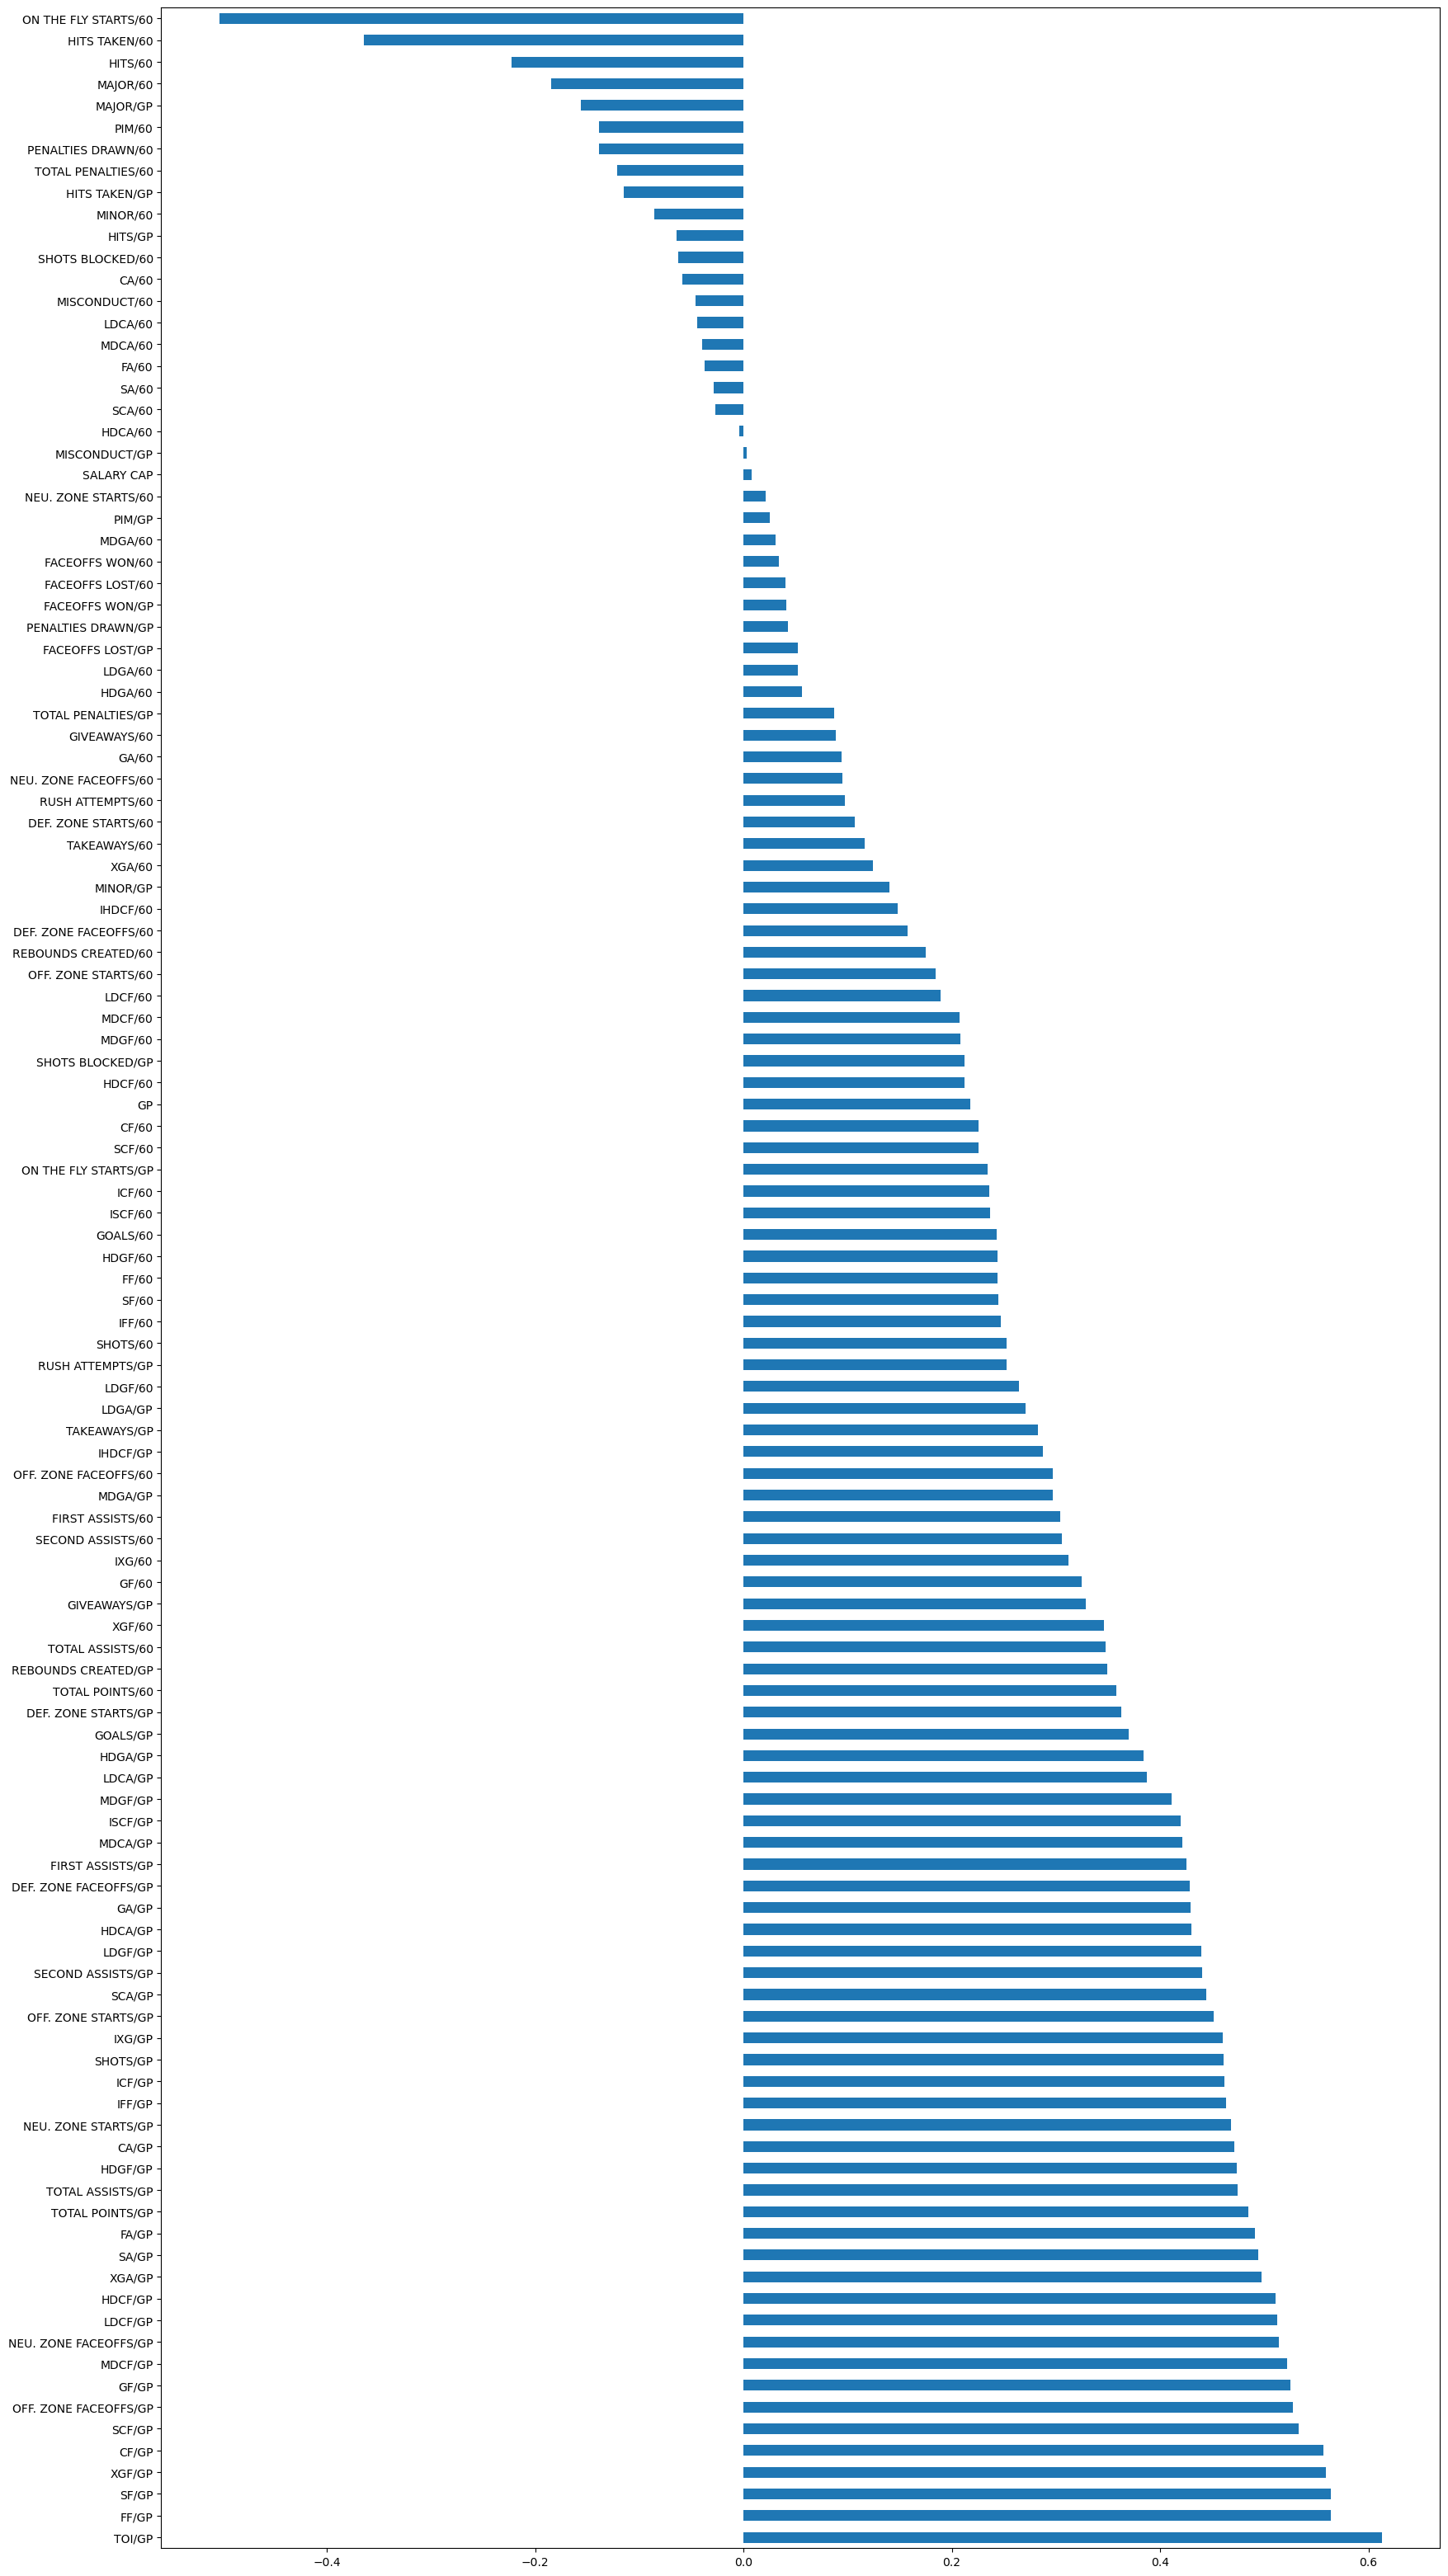

In [9]:
correlation_matrix = defensemen_41GP.corr()

# Extract all correlations with 'Y_SALARY_CAP_PERCENTAGE' and sort them
correlation_Y = correlation_matrix['SALARY CAP PERCENTAGE'].sort_values(ascending=False)

# Remove Y_SALARY_CAP_PERCENTAGE and LENGTH from the list
correlation_Y = correlation_Y.drop(['SALARY CAP PERCENTAGE', 'AAV'])

# Create a barplot of the correlations
plt.figure(figsize=(20, 40))
correlation_Y.plot(kind='barh')

This is looking pretty promising. One thing that may help is to pull out the top 15 or 20 features that have high absolute correlation values, and graph them.

In [10]:
# Sort the values of 'Y_SALARY_CAP_PERCENTAGE' by the absolute value
correlation_Y_abs = correlation_Y.abs().sort_values(ascending=False)

<Axes: >

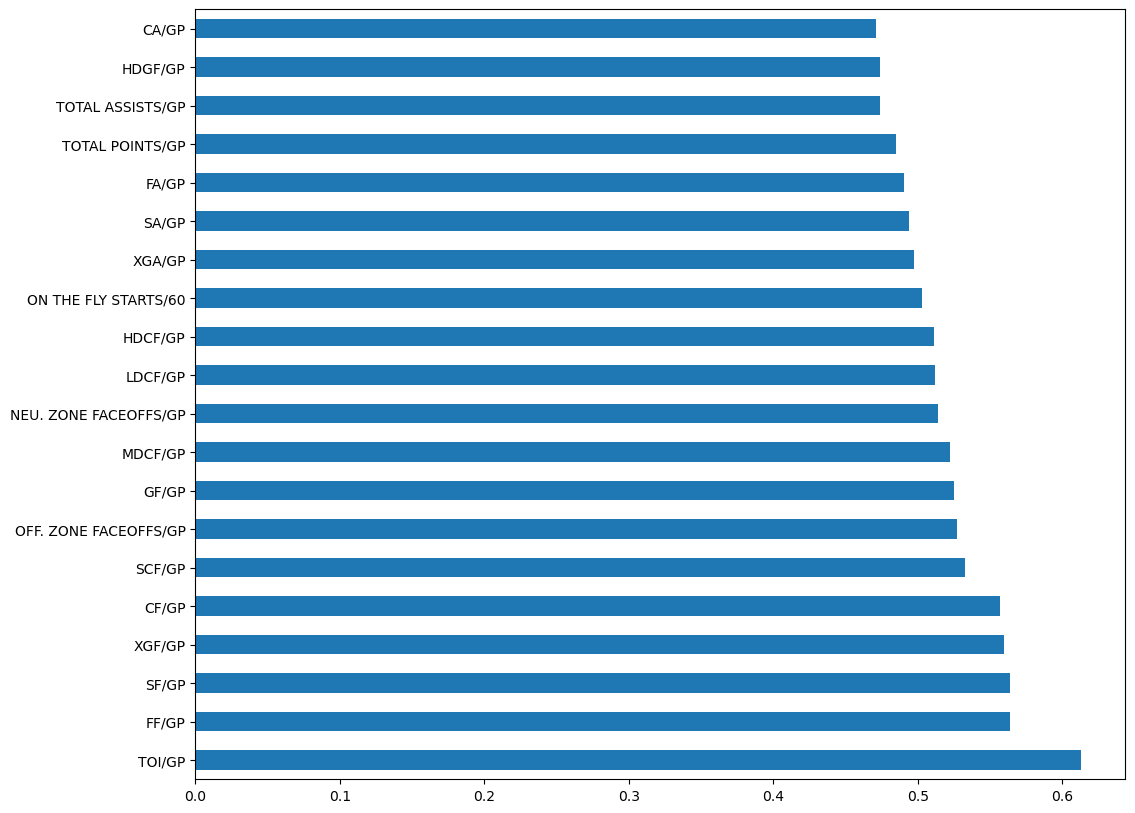

In [11]:
# Create a barplot of the top 20 correlations
plt.figure(figsize=(12, 10))
correlation_Y_abs[:20].plot(kind='barh')

In [12]:
correlation_Y_abs[:15].index.tolist()

['TOI/GP',
 'FF/GP',
 'SF/GP',
 'XGF/GP',
 'CF/GP',
 'SCF/GP',
 'OFF.\xa0ZONE FACEOFFS/GP',
 'GF/GP',
 'MDCF/GP',
 'NEU.\xa0ZONE FACEOFFS/GP',
 'LDCF/GP',
 'HDCF/GP',
 'ON\xa0THE\xa0FLY STARTS/60',
 'XGA/GP',
 'SA/GP']

## Interesting Finding

Something I find quite interesting here is the strong (negative) correlation with On the fly starts per 60 minutes. An interesting element of hockey is the fact that players on the ice can swap with players on the bench, making an "on the fly" shift change in the middle of action. The strong negative correlation here with salary highlights the fact that these players come on the ice in the middle of play and are *less* likely to start play on the ice (at a face-off). This says something about game management and coaching decisions, suggesting that coaches want to start play with their best players on the ice. Players that frequently come onto the ice in the middle of play then are probably more likely to be used in specific game situations.

# Covariance Analysis

Next thing I'd like to look into is covariance analysis. Simply choosing the top features will not necessarily be useful if they are all themselves correlated. If we find that they are, it will probably make more sense to choose one and use that.

In [13]:
# Extract the top 15 positively correlated features
top_20_features = correlation_Y[correlation_Y > 0].nlargest(30)

positive_corrs_df = defensemen_41GP[top_20_features.index]
positive_corrs = positive_corrs_df.corr()

## TOI/GP Multicollinearity Analysis

<Axes: >

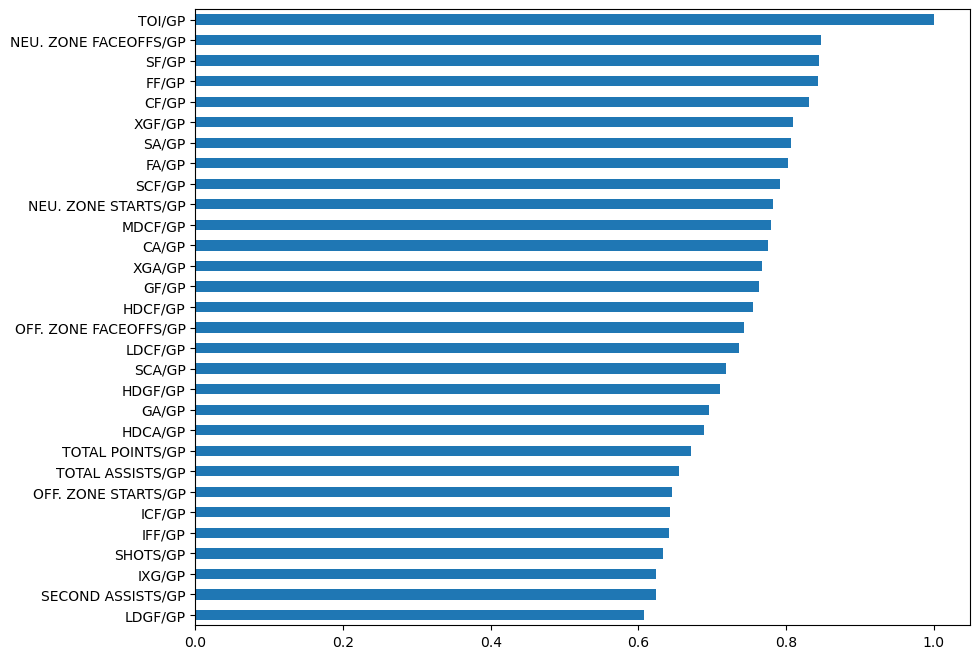

In [15]:
# Sort positive_corrs by 'TOI/GP'
TOI_corrs = positive_corrs['TOI/GP'].sort_values()

# Plot a bar graph of TOI/GP vs. the top positively correlated features
plt.figure(figsize=(10, 8))
TOI_corrs.plot(kind='barh')

In [17]:
TOI_corrs.index.tolist()

['LDGF/GP',
 'SECOND ASSISTS/GP',
 'IXG/GP',
 'SHOTS/GP',
 'IFF/GP',
 'ICF/GP',
 'OFF.\xa0ZONE STARTS/GP',
 'TOTAL ASSISTS/GP',
 'TOTAL POINTS/GP',
 'HDCA/GP',
 'GA/GP',
 'HDGF/GP',
 'SCA/GP',
 'LDCF/GP',
 'OFF.\xa0ZONE FACEOFFS/GP',
 'HDCF/GP',
 'GF/GP',
 'XGA/GP',
 'CA/GP',
 'MDCF/GP',
 'NEU.\xa0ZONE STARTS/GP',
 'SCF/GP',
 'FA/GP',
 'SA/GP',
 'XGF/GP',
 'CF/GP',
 'FF/GP',
 'SF/GP',
 'NEU.\xa0ZONE FACEOFFS/GP',
 'TOI/GP']

### Results

Here we see that Time on Ice per Game Played is highly correlated with a range of features, but not quite as highly as with the forwards. Interestingly, Neutral zone faceoffs is highly correlated.

## NEU.\xa0ZONE FACEOFFS/GP Multicollinearity Analysis

<Axes: >

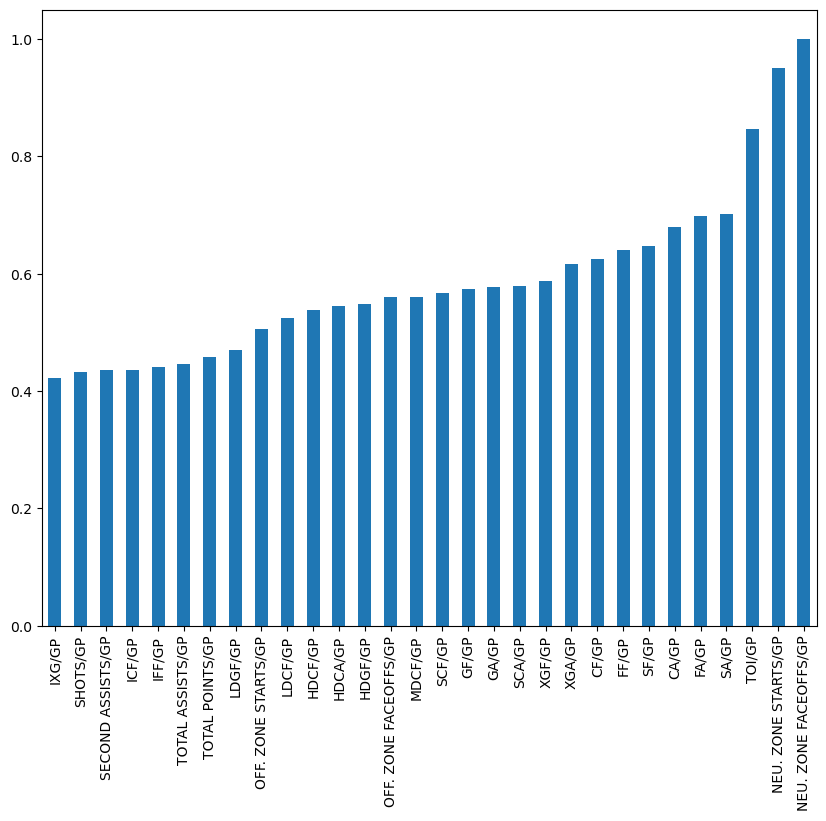

In [20]:
# Sort positive_corrs by 'TOI/GP'
NEU_corrs = positive_corrs['NEU.\xa0ZONE FACEOFFS/GP'].sort_values()

# Plot a bar graph of XGF/60 vs. the top positively correlated features, sorted by XGF/60
plt.figure(figsize=(10, 8))
NEU_corrs.plot(kind='bar')

### Results

Here we do not see much correlateion with anything other than TOI/GP and Neurtral Zone Starts.

## FF/GP Multicollinearity Analysis

<Axes: >

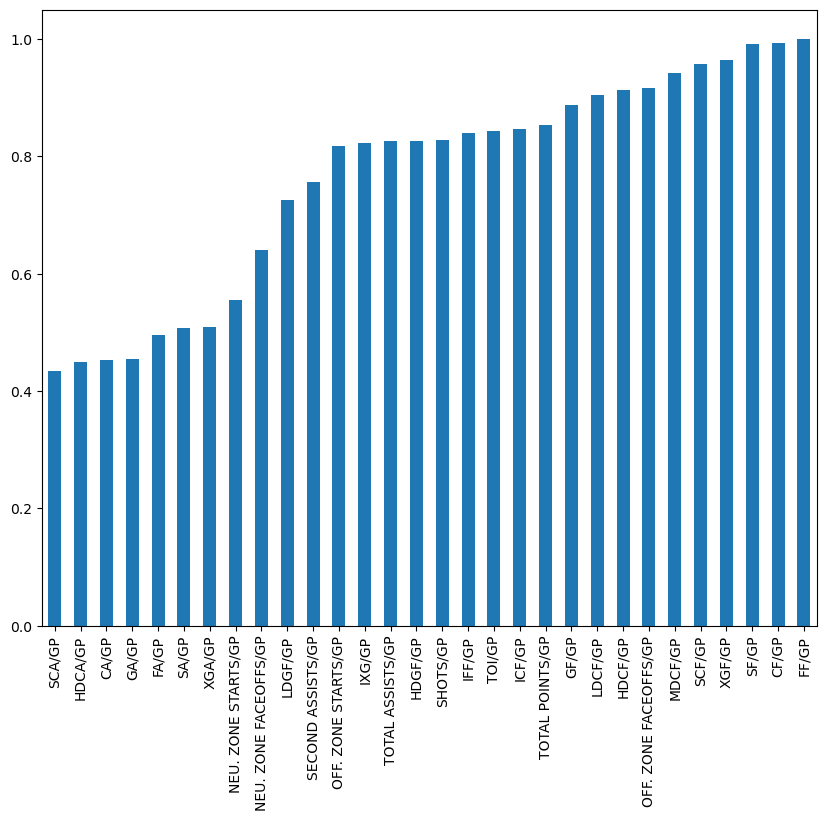

In [21]:
# Sort positive_corrs by 'TOI/GP'
FF_corrs = positive_corrs['FF/GP'].sort_values()

# Plot a bar graph of TOI/GP vs. the top positively correlated features
plt.figure(figsize=(10, 8))
FF_corrs.plot(kind='bar')

### Results

Here we see that FF/GP (Fenwick For) is highly correlated with CF (Corsi For) which is not surprising, since they are advanced metrics that are built off of similar standard statistics.

## 'SF/GP' Multicollinearity Analysis

<Axes: >

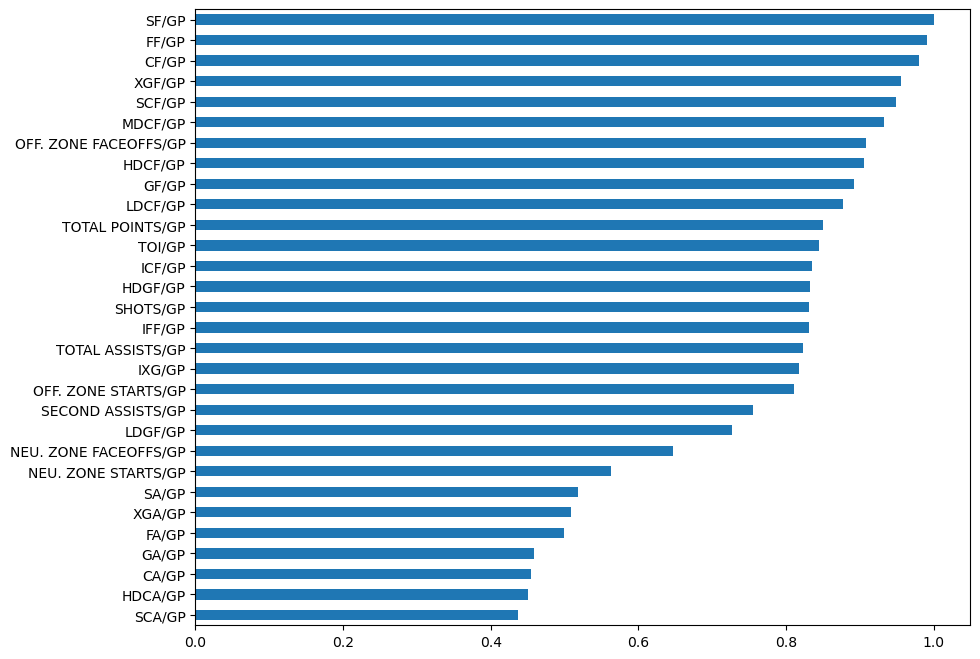

In [23]:
SF_corrs = positive_corrs['SF/GP'].sort_values()

# Plot a bar graph of GF/60 vs. the top positively correlated features
plt.figure(figsize=(10, 8))
SF_corrs.plot(kind='barh')

### Results
Here we see that SF (Shots for) is highly correlated with about 20 other metrics.

#### Thoughts
Due to these high degrees of collinearity, it may make sense to simply use one or two features to explain the rest. Or we could include all the features, and sacrifice explainability.

## XGF/GP Multicollinearity Analysis

<Axes: >

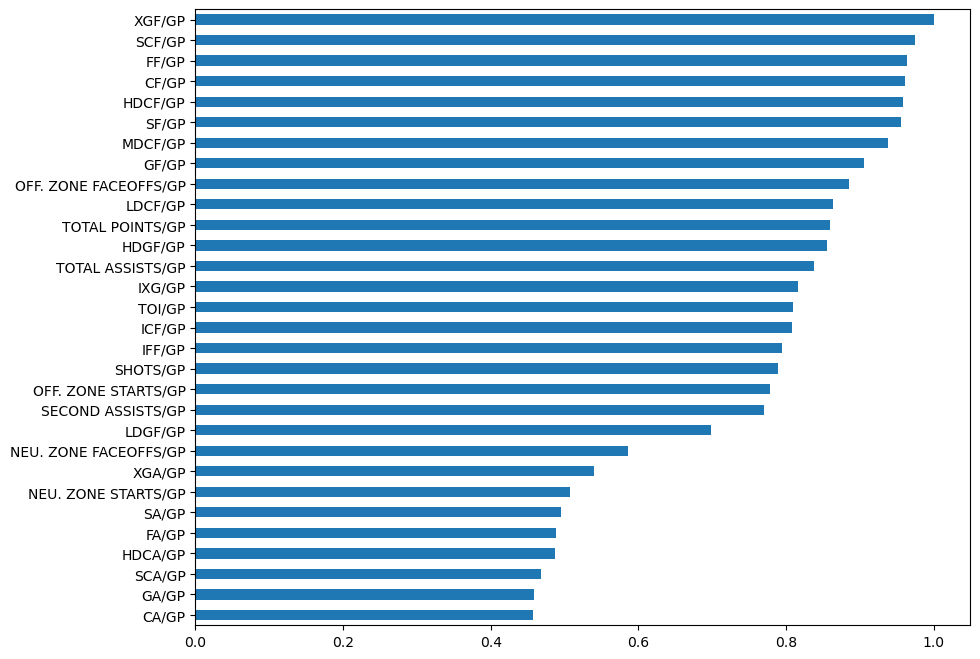

In [24]:
# Sort positive_corrs by XGF/GP
XGF_corrs = positive_corrs['XGF/GP'].sort_values()

# Plot a bar graph of TOTAL ASSISTS/60 vs. the top positively correlated features
plt.figure(figsize=(10, 8))
XGF_corrs.plot(kind='barh')

# Non-Numerical Feature Analysis
Now that we have done a feature analysis for our numerical columns, we should take a look at our non-numerical columns and see if there is anything worth using.

In [25]:
# Select all non-numerical columns from the centers_21GP df
non_numeric_columns = defensemen_41GP.select_dtypes(exclude=['number'])
non_numeric_columns

,TEAM,PLAYER,POSITION,HANDED,SEASON
6,van,alexander edler,d,Left,2007-08
11,atl,alexei zhitnik,d,Left,2007-08
12,det,andreas lilja,d,Left,2007-08
13,mtl,andrei markov,d,Left,2007-08
14,ott,andrej meszaros,d,Left,2007-08
...,...,...,...,...,...
12117,sea,vince dunn,d,Left,2023-24
12118,edm,vincent desharnais,d,Right,2023-24
12123,l.a,vladislav gavrikov,d,Left,2023-24
12141,"min, t.b",zach bogosian,d,Right,2023-24


# One-Hot-Encoding
Most of these features do not seem like anything that should impact the value of a player based on their on-ice performace; however, there is one feature here that intruiges me: handedness. Players are either left-handed or right-handed, and one may be more rare than the other, so it may impact the equation of supply and demand on the market.

Let's do a quick analysis of the counts for each to see if we should use it in our feature space.

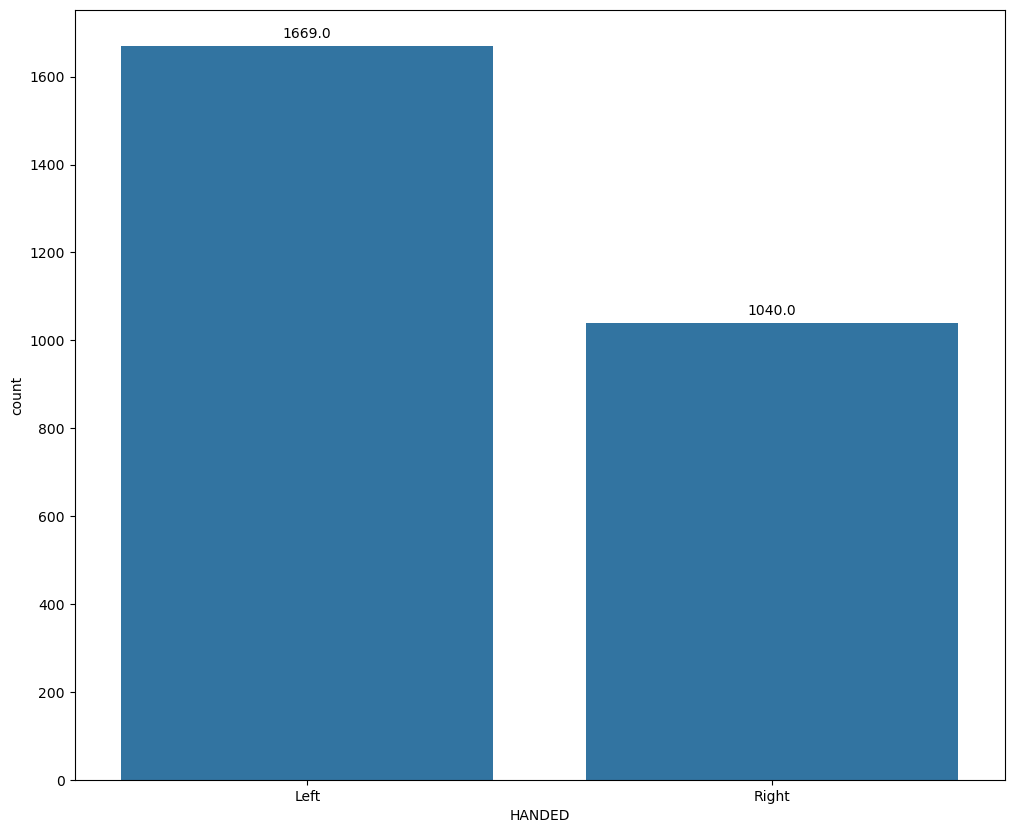

In [26]:
# Assuming centers_21GP is your DataFrame and 'HANDED' is the column of interest
plt.figure(figsize=(12, 10))
ax = sns.countplot(data=defensemen_41GP, x='HANDED')

# Loop through each bar (patch) in the countplot
for p in ax.patches:
    # Get the height of the bar, which represents the count
    height = p.get_height()
    # Annotate the count above the bar
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), # Position for the annotation
                ha='center', va='center', # Alignment parameters
                xytext=(0, 9), # Distance from the top of the bar
                textcoords='offset points') # How the text is positioned

### Results
Interesting, as I suspected, the handedness is not distributed equally among players.

Text(0.5, 1.0, 'Salary Cap Percentage by Handedness')

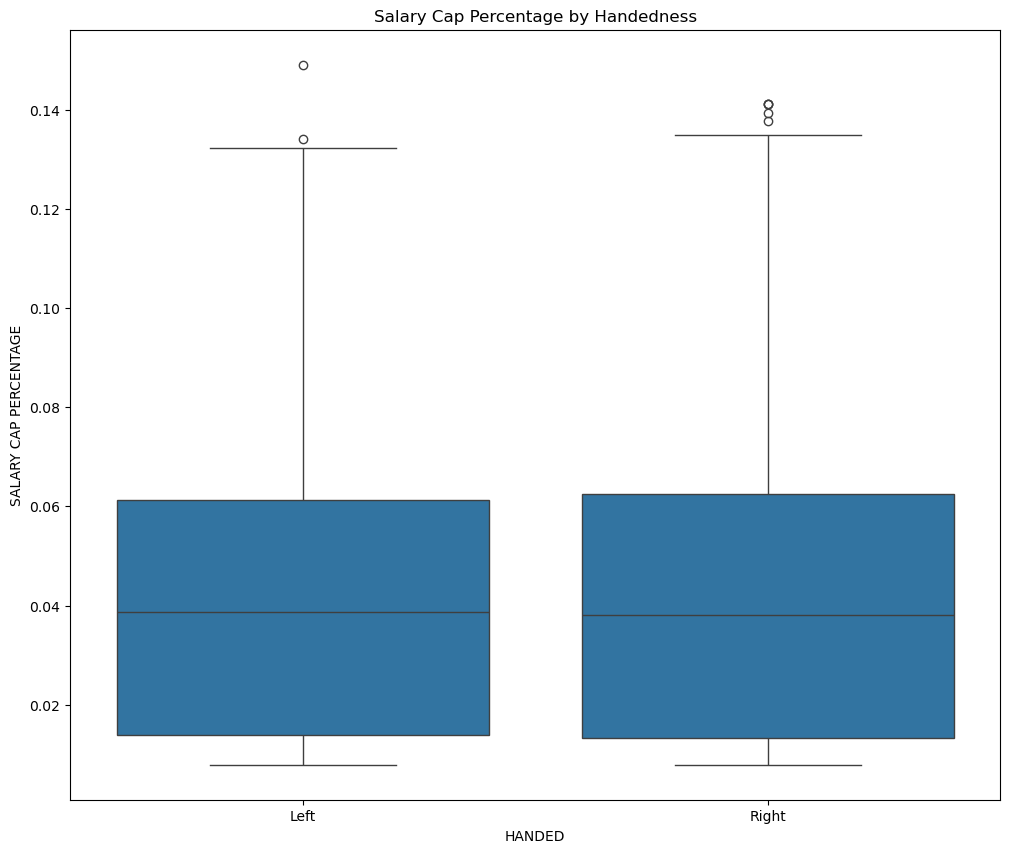

In [27]:
# Visualize a boxplot showing the relationship between handedness and salary cap percentage
plt.figure(figsize=(12, 10))
sns.boxplot(data=defensemen_41GP, x='HANDED', y='SALARY CAP PERCENTAGE')

# Add a title to the plot
plt.title('Salary Cap Percentage by Handedness')

These results suggest that handedness may not in fact have a large impact on our model. Despite the fact that right handed centers are half as common, they do not seem to see a boost in market value.